# Libraries import

If necessary, libraries installation:

In [1]:
import numpy as np
from devito import *
import matplotlib.pyplot as plt
from pyawd import Marmousi
from pyawd.utils import *
from pyawd.GenerateVideo import generate_quiver_video
from tqdm.notebook import tqdm
from glob import glob
from subprocess import call
from os import remove

# Grid definition
We generate a `Grid` in 2D which is $1000$ m large and long.

In [2]:
nx = 32 # space discretisation
dt = 0.01 # time discretisation
nt = 1000 # number of timesteps

grid = Grid(shape=(nx, nx), extent=(1000., 1000.), dtype=np.double)

# External force

In [3]:
s_x, s_y = create_explosive_source(nx)

s_t = np.exp(-(dt)*(np.arange(nt)-(nt//10))**2)

Text(0, 0.5, 'Scaling factor')

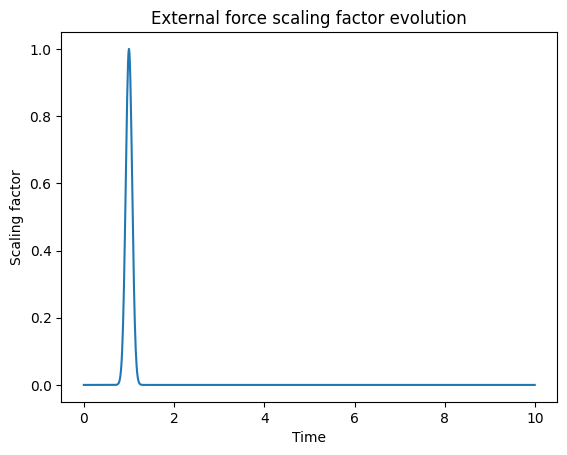

In [4]:
plt.plot(np.arange(nt)*dt, s_t)
plt.title("External force scaling factor evolution")
plt.xlabel("Time")
plt.ylabel("Scaling factor")

In [5]:
s_x_t = np.array([s_x*s_t[t] for t in range(len(s_t))])
s_y_t = np.array([s_y*s_t[t] for t in range(len(s_t))])

We define the external force evolution:

In [6]:
f = VectorTimeFunction(name='f', grid=grid, space_order=1, save=nt, time_order=1)
f[0].data[:] = s_x_t
f[1].data[:] = s_y_t

We generate a video named `f.mp4`:

In [10]:
ddt = 10
generate_quiver_video(f[0].data[::ddt], f[1].data[::ddt], name="VectorAcousticWavePropagation_f", nx=nx, dt=ddt*dt)

  0%|          | 0/100 [00:00<?, ?it/s]

## Equation
The PDE we want to solve is 
$$\frac{d^2u}{dt^2} = c\nabla^2 u + f$$

In [13]:
u = VectorTimeFunction(name='u', grid=grid, space_order=2, save=nt, time_order=2)

c = Function(name="c", grid=grid)
c.data[:] = Marmousi(nx).get_data()
c.data[:] *= (100/np.max(c.data[:]))

eq = Eq(u.dt2, f + (c**2)*u.laplace)

stencil = solve(eq, u.forward)

op = Operator([Eq(u.forward, stencil)], opt='noop')

op.apply(dt=dt)

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.007184999999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [14]:
eq

Eq(Vector(Derivative(u_x(time, x + h_x/2, y), (time, 2)), Derivative(u_y(time, x, y + h_y/2), (time, 2))), Vector((Derivative(u_x(time, x + h_x/2, y), (x, 2)) + Derivative(u_x(time, x + h_x/2, y), (y, 2)))*c(x, y)**2 + f_x(time, x + h_x/2, y), (Derivative(u_y(time, x, y + h_y/2), (x, 2)) + Derivative(u_y(time, x, y + h_y/2), (y, 2)))*c(x, y)**2 + f_y(time, x, y + h_y/2)))

We generate a video fo the evolution of `u`:

In [15]:
ddt=2
generate_quiver_video(u[0].data[::ddt], u[1].data[::ddt], name="VectorAcousticWavePropagation_u", nx=nx, dt=ddt*dt, c=c)

  0%|          | 0/500 [00:00<?, ?it/s]